# Billboard - Análises iniciais

### *Como coletamos os dados?*


A partir desse código:

In [32]:
'''

import pandas as pd
import musicbrainzngs as mbz
import time

# Initialize MusicBrainz
mbz.set_useragent("MyMusicApp", "1.0", "myemail@example.com")

# Function to fetch additional artist info from MusicBrainz
def fetch_artist_info(artist_name):
    try:
        result = mbz.search_artists(query=artist_name, limit=1)
        artist = result['artist-list'][0] if result['artist-list'] else None
        if artist:
            country = artist.get('area', {}).get('name', 'Unknown')
            tags = artist.get('tag-list', [])
            genre = tags[0]['name'] if tags else 'Unknown'
            return country, genre
    except Exception as e:
        print(f"Error fetching info for artist {artist_name}: {e}")
    return 'Unknown', 'Unknown'

# Read the existing CSV file into a DataFrame
df = pd.read_csv("songs_and_artists.csv")

# Add columns for country and genre
df['Country'] = 'Unknown'
df['Genre'] = 'Unknown'

# Fetch and add additional info for each artist
for index, row in df.iterrows():
    country, genre = fetch_artist_info(row['Artist'])
    df.at[index, 'Country'] = country
    df.at[index, 'Genre'] = genre
    time.sleep(1)  # Adding a delay to avoid rate limiting
# Save the updated DataFrame back to a CSV file
df.to_csv("updated_songs_and_artists.csv", index=False)

'''
""""""

''

O que ele faz é, basicamente, pesquisar o nome do artista e da música no MusicBrainz, recolheno o primeiro resultado e armazenando em um arquivo .csv. Esse resultado conta com várias informações sobre a música, incluindo tag do artista (que geralmente corresponde ao gênero) e área (que intuitivamente seria o País de origem).

### *Mas qual o problema?*

O problema principal aqui é que nem toda tag é o gênero e nem toda área é o pais. Os dados recolhidos são menos filtrados do que esperamos, o que significa que podemos ter problemas como aparecer o gênero 'Death by cancer' porque era uma tag relacionada ao artista ou o país 'Rio de Janeiro', porque foi a área de lançamento da música. O que complica mais a situação é o fato de esses problemas estarem diretamente na fonte dos dados e ainda não encontramos uma forma efetiva de automatizar o processo de mudar e filtrar melhor esses dados a partir de um código. 


Assim, conseguimos filtrar algumas linhas, e realizamos as análises inicias a seguir. 

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

# !pip install babypandas
import babypandas as bpd
import pandas as pd

In [2]:
songsArtists = bpd.read_csv('songs_and_artists_updated.csv')
songsArtists

,Year,Position,Song,Artist,Country,Genre
0,1960,1,Theme From A Summer Place,Percy Faith,Canada,death by cancer
1,1960,2,Banho De Lua,Celly Campello,Brazil,rock and roll
2,1960,3,A Noite Do Meu Bem,Dolores Duran,Brazil,samba
3,1960,4,Esmeralda,Carlos José,Brazil,brazilian singer
4,1960,5,Mulher De Trinta,Miltinho,Brazil,samba
...,...,...,...,...,...,...
6395,2023,96,Haja colirio,"Guilherme e Benuto, Hugo e Guilherme",Brazil,Unknown
6396,2023,97,Ela,"Sorriso Maroto, Ferrugem",Brazil,Unknown
6397,2023,98,Perfeito pra ficar sozinho,"Murilo Huff, Maiara e Maraísa",Brazil,Unknown
6398,2023,99,Daqui pra sempre,"Manu, Simone Mendes",Brazil,Unknown


## Análise da influência estadunidense na billboard

Apesar de termos, por enquanto, de forma concretizada, apenas os dados das músicas no Brasil, resolvemos realizar uma análise primitiva. sabemos que os dados de País e Gênero precisam de ajustes - o que pretendemos finalizar em breve. Porém, pensamos em fazer uma análise breve, apenas para termos uma ideia inicial de pesquisa. 

Já em uma análise breve, percebemos que várias das inconsistências que existiam com relação à país foram resolvidas, apesar de termos alterado isso manualmente. Nos índices apresentados, por exemplo, o índice 2 aparecia como 'Rio de Janeiro'.

In [6]:
songsArtists.get('Country')

0       Canada
1       Brazil
2       Brazil
3       Brazil
4       Brazil
         ...  
6395    Brazil
6396    Brazil
6397    Brazil
6398    Brazil
6399    Brazil
Name: Country, Length: 6400, dtype: object

Para uma análise inicial podemos entender como a influência dos EUA se comportou ao longo dos anos. 

In [7]:
songsUS = songsArtists[songsArtists.get('Country')=='United States']

In [8]:
usYear = songsUS.groupby('Year').count().reset_index()
usYear

,Year,Position,Song,Artist,Country,Genre
0,1960,15,15,15,15,15
1,1961,15,15,15,15,15
2,1962,27,27,27,27,27
3,1963,22,22,22,22,22
4,1964,16,16,16,16,16
...,...,...,...,...,...,...
58,2019,1,1,1,1,1
59,2020,4,4,4,4,4
60,2021,1,1,1,1,1
61,2022,3,3,3,3,3


<Axes: title={'center': 'Quantidade de músicas estadunidenses no Billboard brasileiro ao longo dos anos'}, xlabel='Ano', ylabel='Quantidade'>

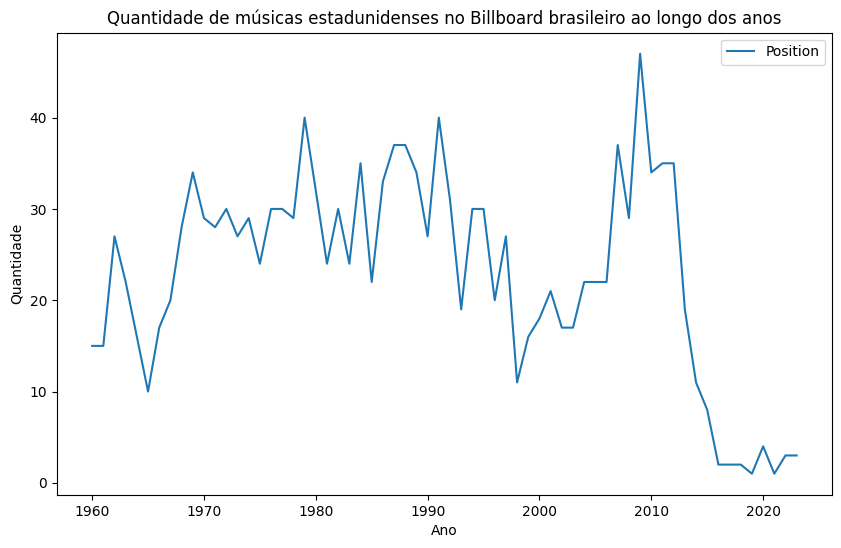

In [9]:
usYear.plot(
    kind='line',
    x='Year',      # Especifica a coluna para o eixo X
    y='Position',     
    xlabel='Ano',
    ylabel='Quantidade',
    title='Quantidade de músicas estadunidenses no Billboard brasileiro ao longo dos anos',
    figsize=(10, 6)
)

Fica perceptível uma certa instabilidade em relação ao número de músicas estadunidenses ao longo dos anos, não seguindo um padrão específico de crescimento ou decrescimento. Analisando brevemente, temos que:
- Na década de 1960, houve uma queda da quantidade de músicas estadunidenses que escutávamos
- Entre 1970 e meados dos anos 1990 cerca de 20 das 100 músicas mais ouvidas vinham dos EUA, o que sofreu uma queda que aafetou até o fim dos anos 2000
- A década de 2010 experienciou uma brusca queda do número de músicas exportadas dos EUA que ficavam no top 10, o que parece se manter na década de 2020.

Para ficar mais evidente, vamos realizar uma análise por década

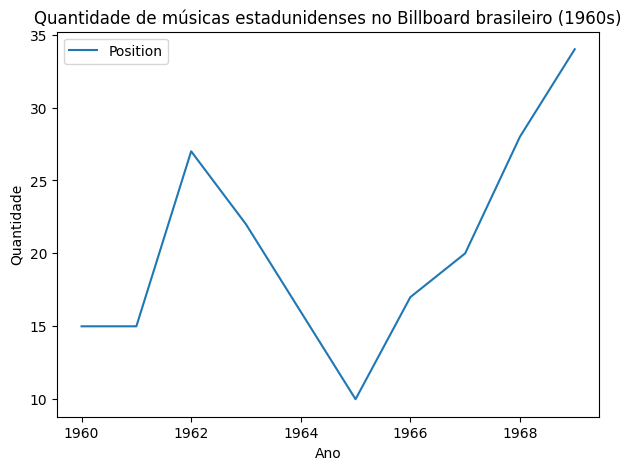

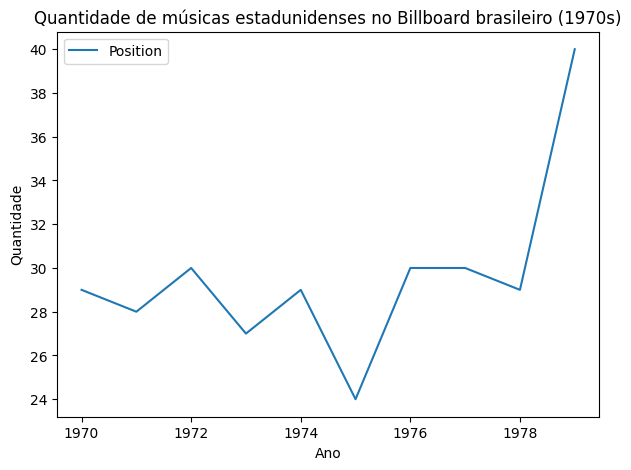

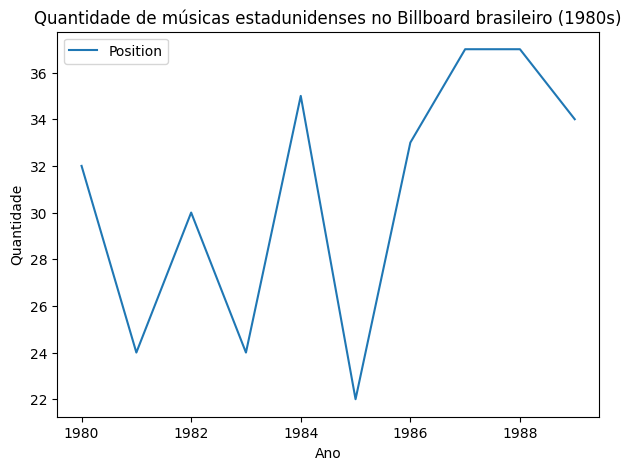

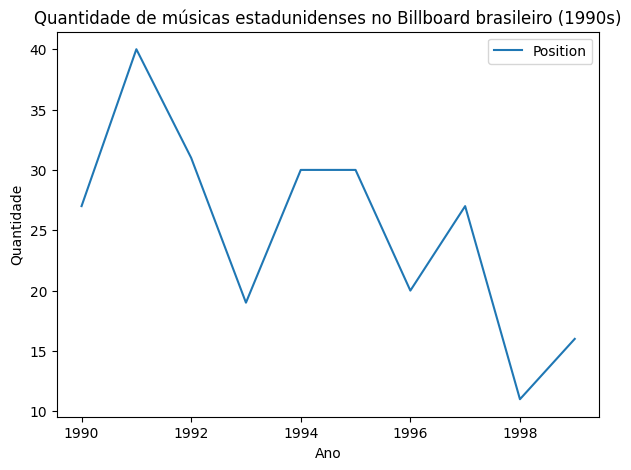

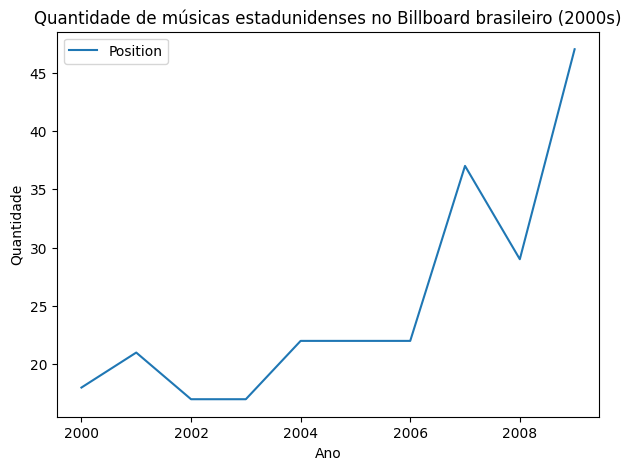

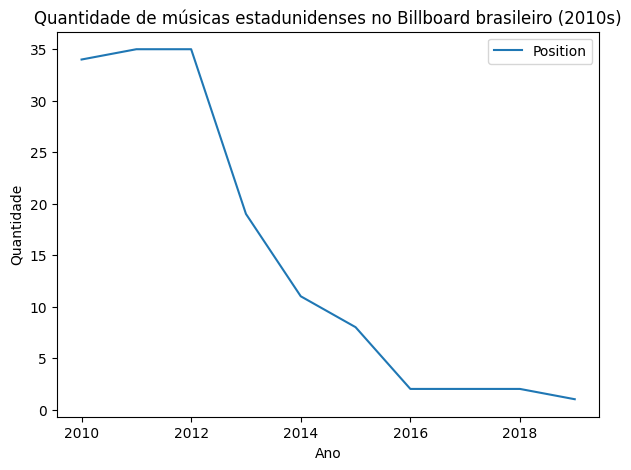

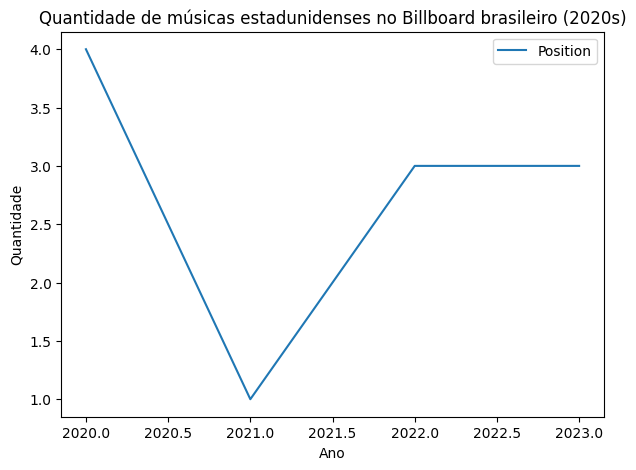

In [12]:
# Função para filtrar dados por década no BabyPandas
def filtrar_decada(df, decada):
    inicio = decada
    fim = decada + 9
    # Filtrando o DataFrame com .loc
    return df.loc[(df.get('Year') >= inicio) & (df.get('Year') <= fim)]

# Lista de décadas de 1960 a 2020
decadas = [1960, 1970, 1980, 1990, 2000, 2010, 2020]

# Loop para gerar gráficos de cada década
for decada in decadas:
    # Filtra o DataFrame para a década atual
    df_decada = filtrar_decada(usYear, decada)
    
    # Gera o gráfico de linhas para a década
    df_decada.plot(
        kind='line',
        x='Year',
        y='Position',
        xlabel='Ano',
        ylabel='Quantidade',
        title=f'Quantidade de músicas estadunidenses no Billboard brasileiro ({decada}s)',
        figsize=(7, 5)
    )
    
    # Exibe o gráfico
    plt.show()


Ao analisar por década, ficam mais visíveis as tendências de aumento e diminuição da influência estadunidense. 
É interessante analisar com calma cada um dos gráficos e perceber que, a partir de 2010, temos uma queda bem acentuada das músicas americanas dentro do billboard brasileiro. 

Apesar de ser uma análise simples, já trouxe fenômenos interessantes:
- As influências se mantêm as mesmas em outros países?
- Com os dados coletados corretamente, essas análises mudam muito?
- O fenômeno da diminuição do número de músicas em 2010 é real? Por que ele ocorre?

*Podemos agora fazer uma breve análise sobre os gêneros das músicas dos EUA presentes no billboard*

In [13]:
songsUS.get('Genre')

9             pop
13           folk
20       american
25       american
33           rock
          ...    
6294         rock
6297         rock
6349         rock
6372    dance-pop
6389         rock
Name: Genre, Length: 1469, dtype: object

In [14]:
groupedGenre = songsUS.groupby(['Genre','Year']).count().reset_index()
groupedGenre

,Genre,Year,Position,Song,Artist,Country
0,Ska,1990,1,1,1,1
1,00s,1987,1,1,1,1
2,1960s,1968,1,1,1,1
3,1960s,1969,1,1,1,1
4,1990s,2000,3,3,3,3
...,...,...,...,...,...,...
787,usa,1979,1,1,1,1
788,usa,1993,1,1,1,1
789,vocal jazz,1984,1,1,1,1
790,vocal jazz,1988,1,1,1,1


Percebemos coisas muito estranhas na coluna gênero. Por isso, vamos definir um grupo de gêneros a serem considerados nesse momento, apenas para que essa análise inicial tenha algum efeito prático. 

In [15]:
# Lista de gêneros que você deseja filtrar
generos = ['pop', 'folk', 'rock', 'hip hop', 'jazz', 'rap']

# Criando a máscara booleana
mask = (
    (groupedGenre.get('Genre') == 'pop') |
    (groupedGenre.get('Genre') == 'folk') |
    (groupedGenre.get('Genre') == 'rock') |
    (groupedGenre.get('Genre') == 'hip hop') |
    (groupedGenre.get('Genre') == 'jazz') |
    (groupedGenre.get('Genre') == 'rap')
)

# Aplicando o filtro ao DataFrame
df_filtrado = groupedGenre.loc[mask]
df_filtrado

,Genre,Year,Position,Song,Artist,Country
330,folk,1960,2,2,2,2
331,folk,1970,1,1,1,1
332,folk,1971,2,2,2,2
333,folk,1974,1,1,1,1
363,hip hop,1977,1,1,1,1
...,...,...,...,...,...,...
681,rock,2016,2,2,2,2
682,rock,2018,1,1,1,1
683,rock,2020,1,1,1,1
684,rock,2022,2,2,2,2


Existem muito mais gêneros e muitos dados estão equivocados, mas aqui conseguimos ter uma leve ideia da divisão de popularidade. 

<Axes: title={'center': 'Quantidade total de músicas estadunidenses no Billboard por gênero'}, ylabel='Genre'>

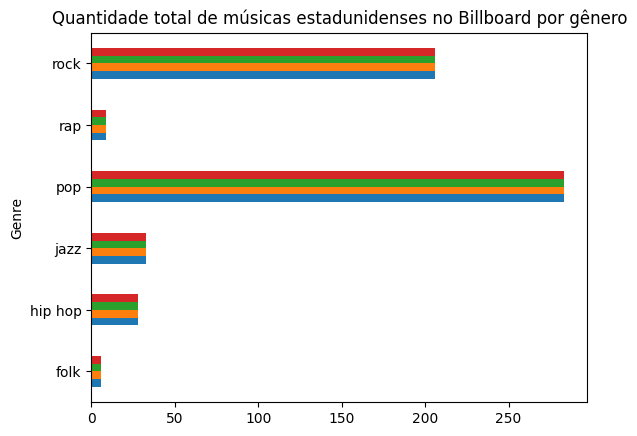

In [16]:
# Total por gênero
groupedOnlyGenre = df_filtrado.groupby('Genre').sum().drop(columns = 'Year')
groupedOnlyGenre.plot(kind = 'barh', legend =False, title = 'Quantidade total de músicas estadunidenses no Billboard por gênero')

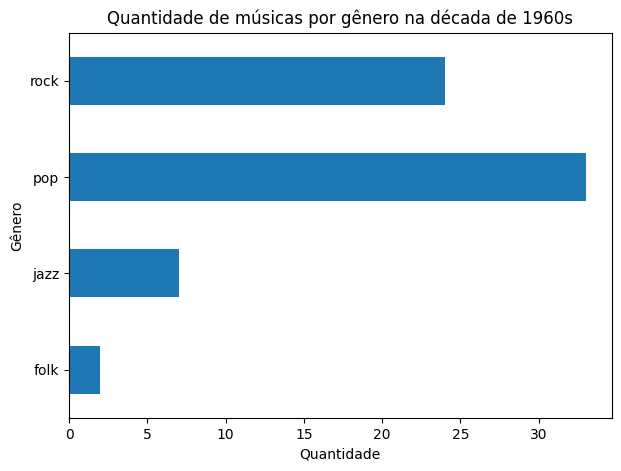

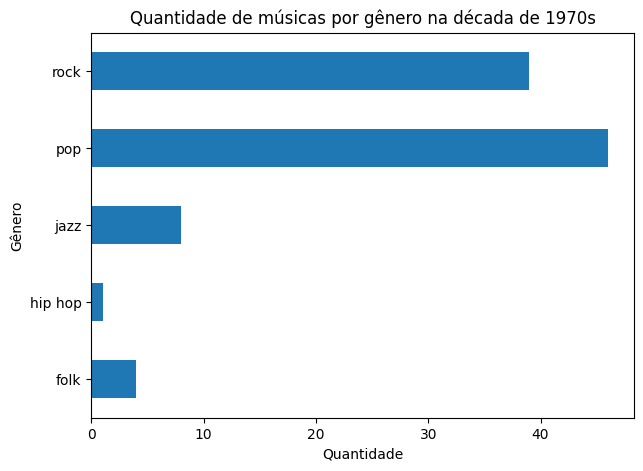

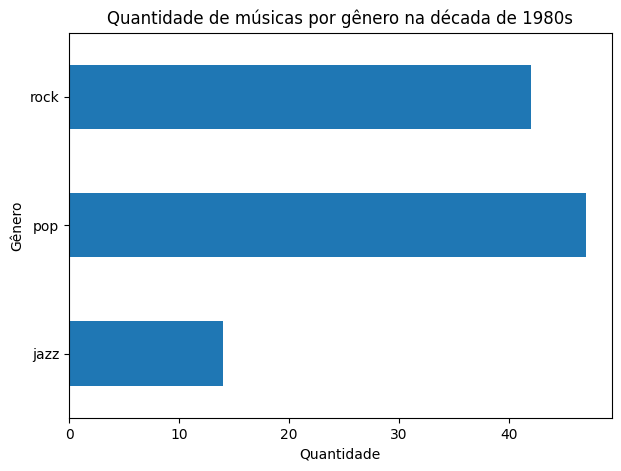

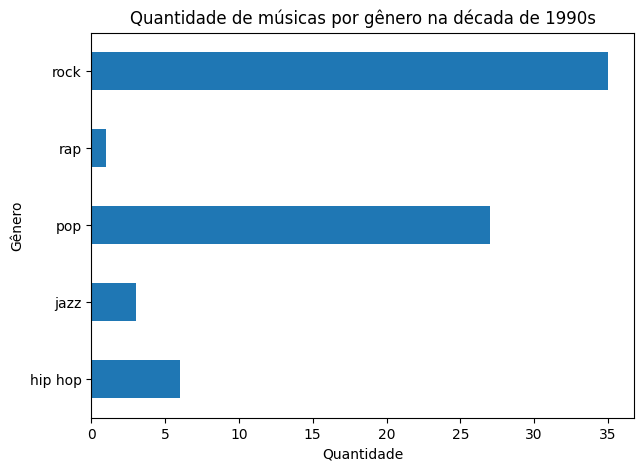

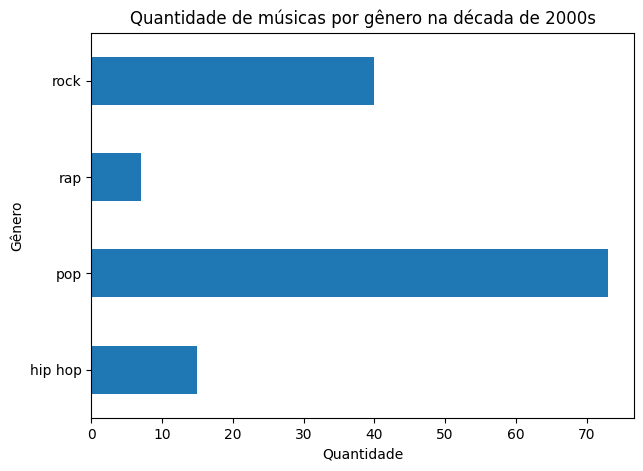

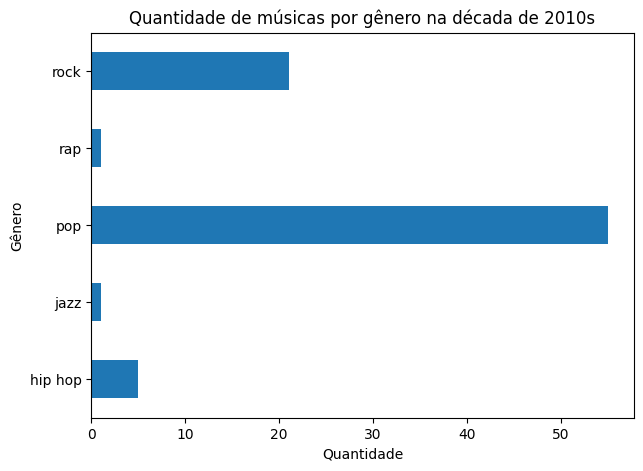

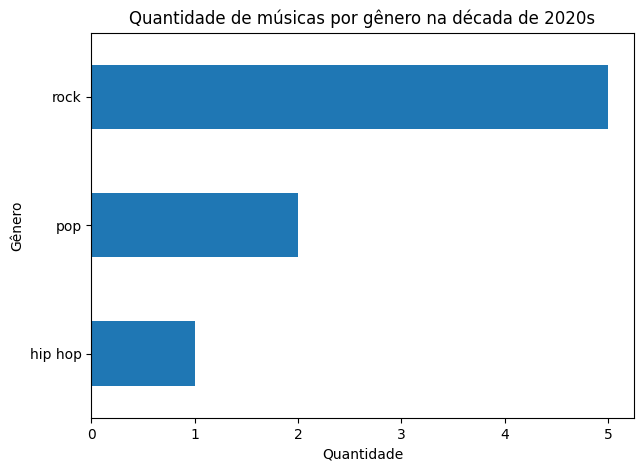

In [17]:
import matplotlib.pyplot as plt

# Função para filtrar dados por década no babypandas
def filtrar_decada(df, decada):
    inicio = decada
    fim = decada + 9
    return df.loc[(df.get('Year') >= inicio) & (df.get('Year') <= fim)]

# Lista de décadas de 1960 a 2020
decadas = [1960, 1970, 1980, 1990, 2000, 2010, 2020]

# Loop para gerar gráficos de cada década
for decada in decadas:
    # Filtra o DataFrame para a década atual
    df_decada = filtrar_decada(df_filtrado, decada)
    
    # Agrupa por gênero e soma as quantidades
    df_genero = df_decada.groupby('Genre').sum().reset_index()

    # Gera o gráfico de barras horizontais
    df_genero.plot(
        kind='barh',   # Gráfico de barras horizontais
        x='Genre',     # Coluna no eixo Y (nomes dos gêneros)
        y='Position',  # Coluna no eixo X (quantidade de músicas)
        xlabel='Quantidade',
        ylabel='Gênero',
        legend = False,
        title=f'Quantidade de músicas por gênero na década de {decada}s',
        figsize=(7, 5)
    )
    
    # Exibe o gráfico
    plt.show()


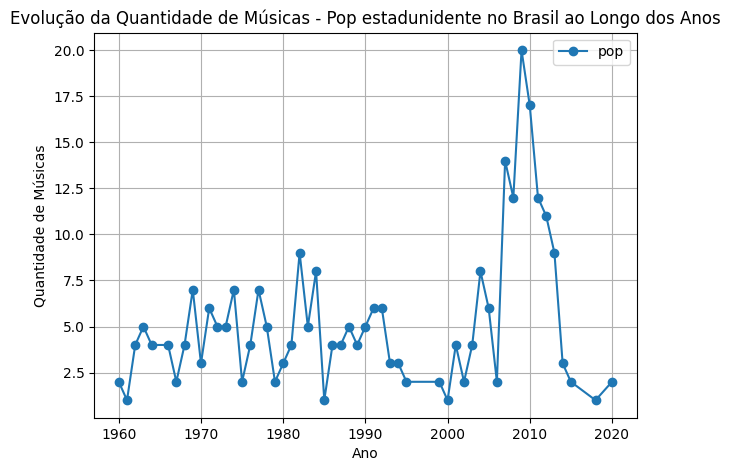

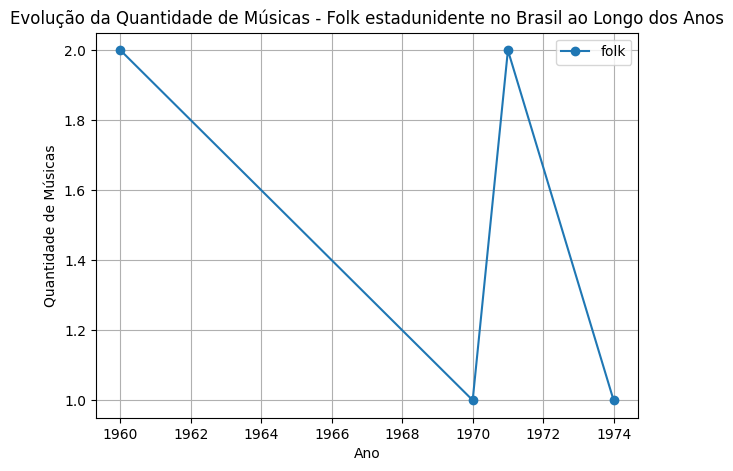

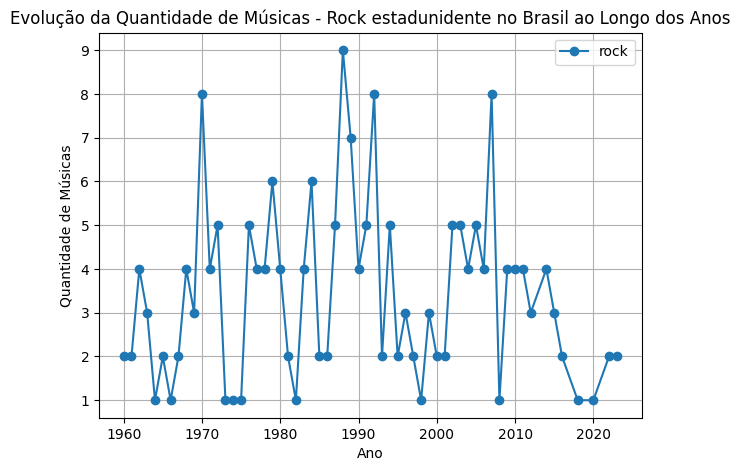

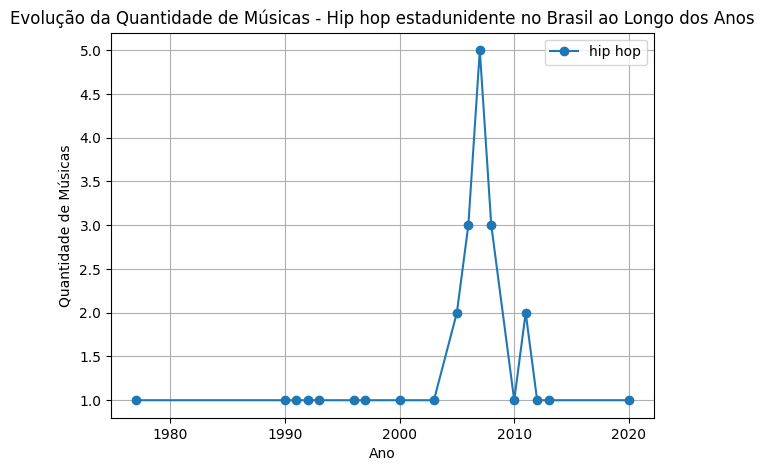

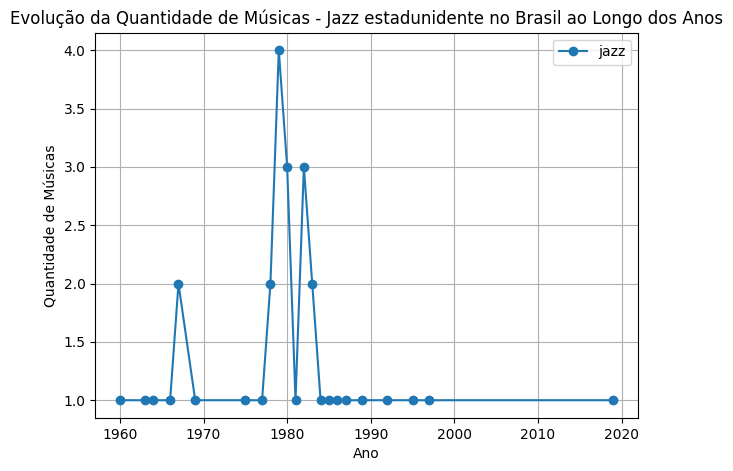

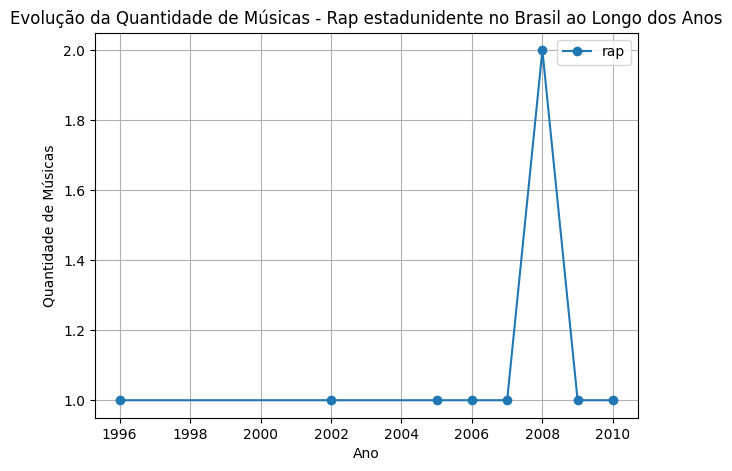

In [30]:
import matplotlib.pyplot as plt

# Lista de gêneros que você deseja plotar
generos = ['pop', 'folk', 'rock', 'hip hop', 'jazz', 'rap']

# Loop para gerar gráficos de linhas para cada gênero
for genero in generos:
    # Filtra o DataFrame para o gênero atual
    df_genero = df_filtrado.loc[df_filtrado.get('Genre') == genero]

    # Gera o gráfico de linhas
    plt.figure(figsize=(7, 5))
    plt.plot(df_genero.get('Year'), df_genero.get('Position'), marker='o', label=genero)
    
    # Configurações do gráfico
    plt.xlabel('Ano')
    plt.ylabel('Quantidade de Músicas')
    plt.title(f'Evolução da Quantidade de Músicas - {genero.capitalize()} estadunidente no Brasil ao Longo dos Anos')
    plt.grid()
    plt.legend()
    
    # Exibe o gráfico
    plt.show()


## Evolução da música brasileira no Brasil

Em que momento passamos a ouvir música nacional? Ela sempre esteve presente nas graças do povo brasileiro? Qual o gênero mais ouvido? A queda da influência estadunidense tem relação com um maior "nacionalismo" auditivo?

São essas as perguntas que vamos começar a responder nesse tópico.

<Axes: title={'center': 'Quantidade de músicas brasileiras no Billboard brasileiro ao longo dos anos'}, xlabel='Ano', ylabel='Quantidade'>

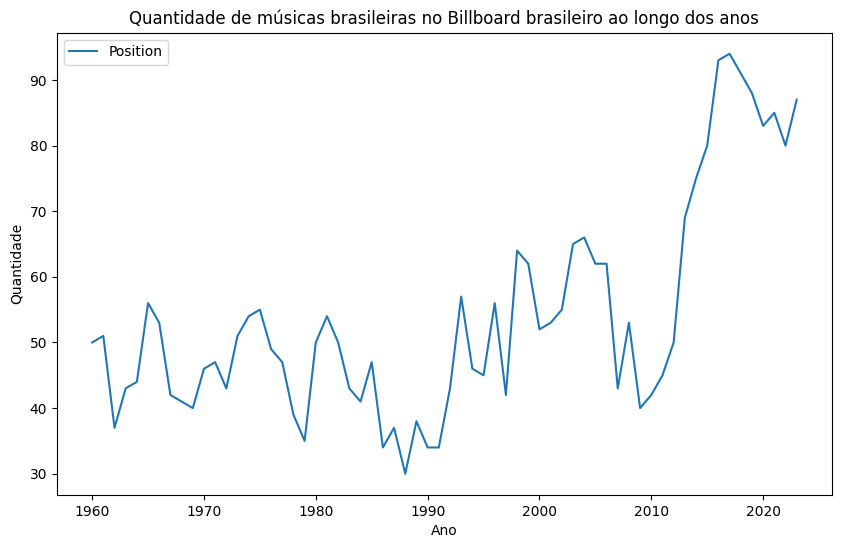

In [61]:
songsBR = songsArtists[songsArtists.get('Country') == 'Brazil']

(songsBR
    .groupby('Year')
    .count()
    .reset_index()
    .plot(
        kind='line',
        x='Year',      # Especifica a coluna para o eixo X
        y='Position',     
        xlabel='Ano',
        ylabel='Quantidade',
        title='Quantidade de músicas brasileiras no Billboard brasileiro ao longo dos anos',
        figsize=(10, 6)
    )
)

Há uma certa estabilidade entre 30 e 50 músicas em quase todo o século XX, o que começa a se alterar no fim da década de 1990. Em meados dos anos 2000, percebemos um leve aumento do número de músicas brasileiras no top100, o que se confirma em 2010, com um aumento rápido e que se mantêm na década de 2020. 

In [42]:
# Lista de gêneros que você deseja filtrar
generos = ['pop', 'samba', 'rock', 'sertanejo', 'funk', 'rap']

# Criando a máscara booleana
mask = (
    (groupedGenre.get('Genre') == 'pop') |
    (groupedGenre.get('Genre') == 'samba') |
    (groupedGenre.get('Genre') == 'rock') |
    (groupedGenre.get('Genre') == 'sertanejo') |
    (groupedGenre.get('Genre') == 'funk') |
    (groupedGenre.get('Genre') == 'rap')
)

# Aplicando o filtro ao DataFrame
df_filtrado_br = groupedGenre.loc[mask]
df_filtrado_br

,Genre,Year,Position,Song,Artist,Country
342,funk,1967,1,1,1,1
343,funk,1976,1,1,1,1
344,funk,1977,1,1,1,1
345,funk,1978,1,1,1,1
346,funk,1979,1,1,1,1
...,...,...,...,...,...,...
681,rock,2016,2,2,2,2
682,rock,2018,1,1,1,1
683,rock,2020,1,1,1,1
684,rock,2022,2,2,2,2


<Axes: title={'center': 'Quantidade total de músicas brasileiras no Billboard por gênero'}, ylabel='Genre'>

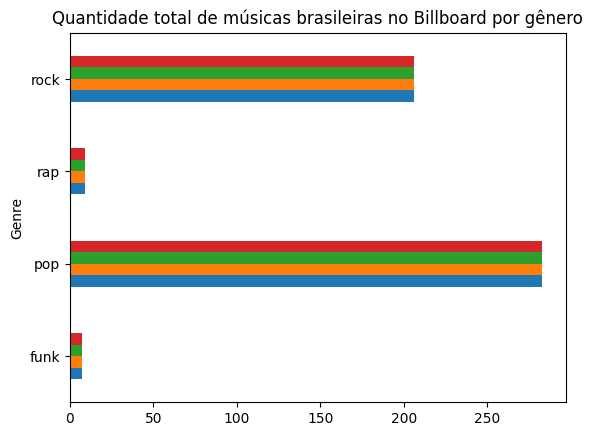

In [43]:
# Total por gênero
groupedOnlyGenreBr = df_filtrado_br.groupby('Genre').sum().drop(columns = 'Year')
groupedOnlyGenreBr.plot(kind = 'barh', legend =False, title = 'Quantidade total de músicas brasileiras no Billboard por gênero')

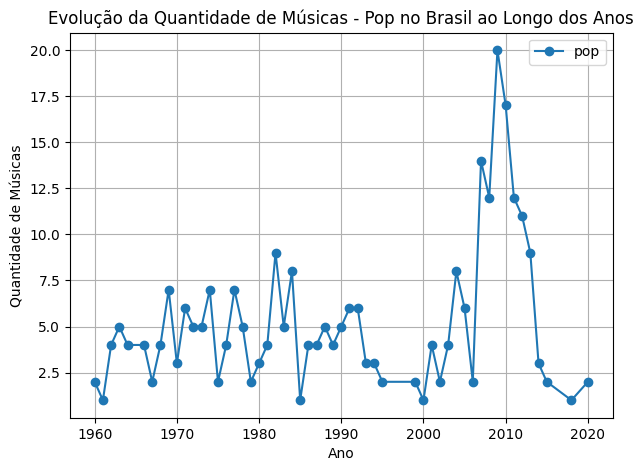

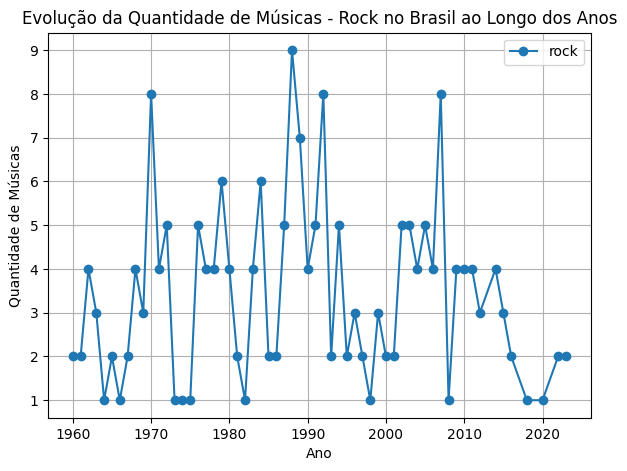

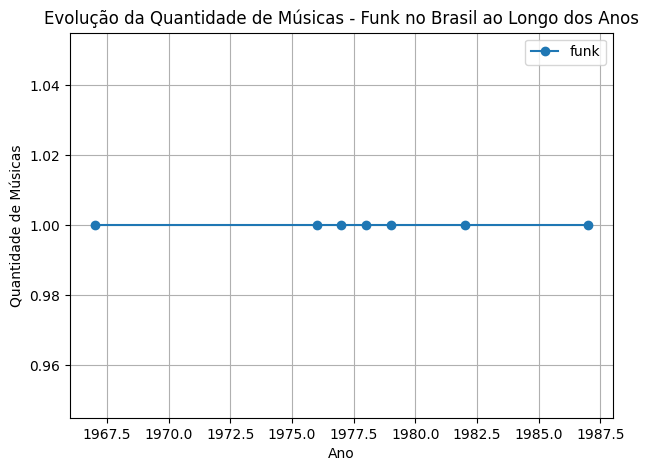

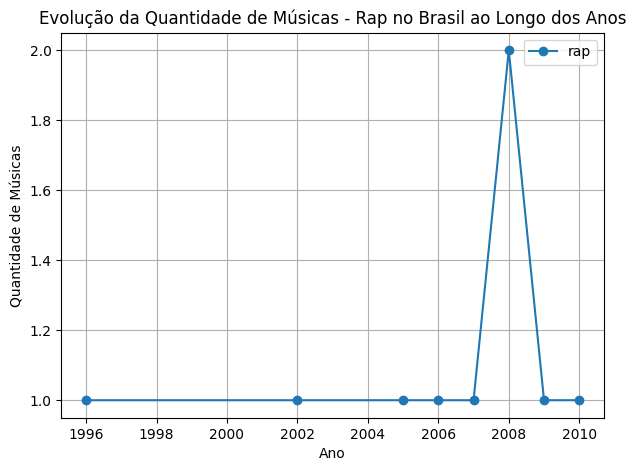

In [48]:
# Lista de gêneros que você deseja plotar
generosBR = ['pop', 'rock', 'funk', 'rap']

# Loop para gerar gráficos de linhas para cada gênero
for genero in generosBR:
    # Filtra o DataFrame para o gênero atual
    df_genero = df_filtrado_br.loc[df_filtrado.get('Genre') == genero]

    # Gera o gráfico de linhas
    plt.figure(figsize=(7, 5))
    plt.plot(df_genero.get('Year'), df_genero.get('Position'), marker='o', label=genero)
    
    # Configurações do gráfico
    plt.xlabel('Ano')
    plt.ylabel('Quantidade de Músicas')
    plt.title(f'Evolução da Quantidade de Músicas - {genero.capitalize()} no Brasil ao Longo dos Anos')
    plt.grid()
    plt.legend()
    
    # Exibe o gráfico
    plt.show()

Os gêneros 'sertanejo' e 'samba' aparecem, na maioria das vezes, como Unknow no csv, o que é um problema na análise, já que, por uma lida rápida na tabela, percebemos que o sertanejo tem liderado o top100 nos últimos anos. 

Apesar desses problemas, essa análise inicial nos permite ter um caminho para onde seguir daqui pra frente

## Dados de outros países

Conseguimos encontrar bases de dados parecidas da Alemanha, Austrália e Estados Unidos. 

A escolha dos países é interessante pois temos uma grande influência em todo o mundo (EUA), um páis distante mas que fala inglês e um europeu. Seria legal se conseguíssemos de um lugar como Japão, Coreia, Nigéria, Africa do Sul e etc, mas estamos encontrando dificuldades nessas procuras. 

- Austrália:
    - https://www.top100singles.net/2014/10/amr-weekly-top-100-singles-charts.html
    - Podemos conseguir encontrar uma forma de automatizar o processo de escolher o ano, recolher os dados e juntar tudo em só 1 csv

- Alemanha:
    - https://www.offiziellecharts.de/
    - Aqui a automatização do processo pode ser mais difícil, pois temos um calendário para selecionar o ano e o dia, mas pode ser possível. Podemos também tentar encontrar de outro país da Europa, que não tenha inglês como língua nativa.

- Estados Unidos da América
    - https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs
    - Os dados já vem como csv, e vem por dia. É de longe a base de dados mais completa que vamos ter, mas as análises em cima dela podem ser sobre a diferença das músicas exportadas e músicas que ficam mais famosas localmente.

### Estados Unidos - Mini análise

In [50]:
billboard  = pd.read_csv('charts_eua.csv')
billboard

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2021-11-06,1,Easy On Me,Adele,1.0,1,3
1,2021-11-06,2,Stay,The Kid LAROI & Justin Bieber,2.0,1,16
2,2021-11-06,3,Industry Baby,Lil Nas X & Jack Harlow,3.0,1,14
3,2021-11-06,4,Fancy Like,Walker Hayes,4.0,3,19
4,2021-11-06,5,Bad Habits,Ed Sheeran,5.0,2,18
...,...,...,...,...,...,...,...
330082,1958-08-04,96,Over And Over,Thurston Harris,NaN,96,1
330083,1958-08-04,97,I Believe In You,Robert & Johnny,NaN,97,1
330084,1958-08-04,98,Little Serenade,The Ames Brothers,NaN,98,1
330085,1958-08-04,99,I'll Get By (As Long As I Have You),Billy Williams,NaN,99,1


Apesar da base ser boa, já identificamos que não contêm a coluna de gênero e país de origem da música. Porém, podemos plotar alguns gráficos sobre quantas semanas permaneceu no top e sobre os artistas. 

<Axes: title={'center': 'Artistas que mais aparecem nos charts dos EUA'}, xlabel='Quantidade', ylabel='Artista'>

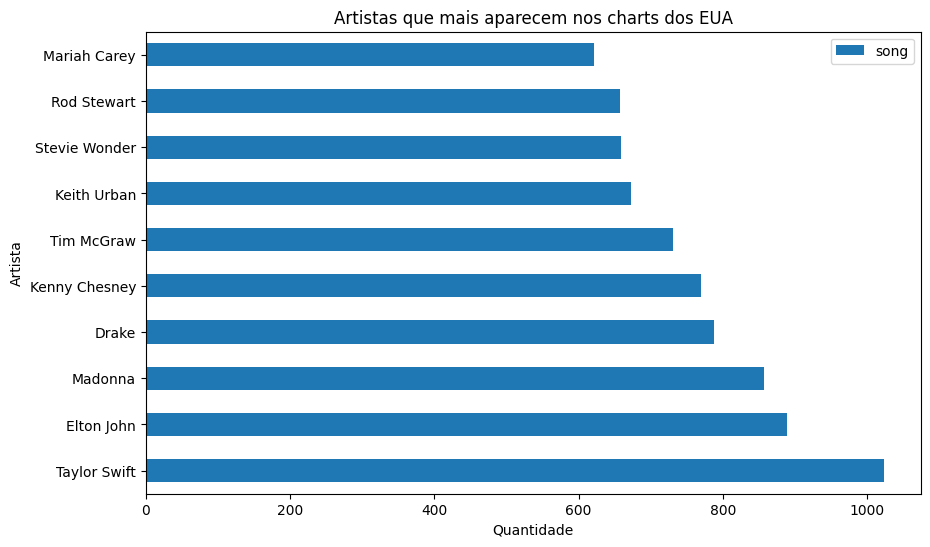

In [58]:
(billboard
    .groupby('artist')
    .count()
    .sort_values(by='song', ascending=False )
    .reset_index()
    .iloc[range(0,10)]
).plot(
        kind='barh',
        x='artist',      # Especifica a coluna para o eixo X
        y='song',     
        xlabel='Quantidade',
        ylabel='Artista',
        title='Artistas que mais aparecem nos charts dos EUA',
        figsize=(10, 6)
)


<Axes: title={'center': 'Quantas músicas conseguem ficar mais semanas no top 100?'}, xlabel='Quantidade de semanas', ylabel='Quantidade de músicas'>

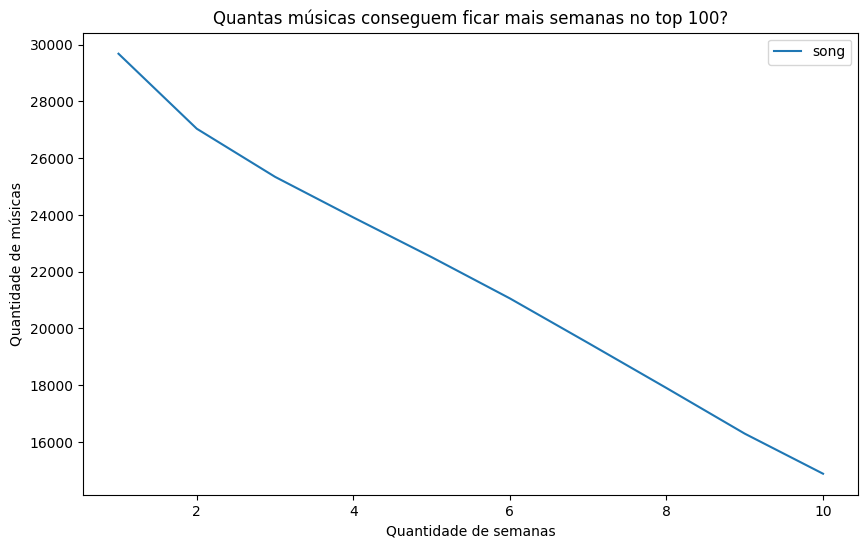

In [60]:
(billboard
    .groupby('weeks-on-board')
    .count()
    .sort_values(by='song', ascending=False )
    .reset_index()
    .iloc[range(0,10)]
).plot(
        kind='line',
        x='weeks-on-board',      # Especifica a coluna para o eixo X
        y='song',     
        xlabel='Quantidade de semanas',
        ylabel='Quantidade de músicas',
        title='Quantas músicas conseguem ficar mais semanas no top 100?',
        figsize=(10, 6)
)

Faz sentido: quanto mais semanas, menos músicas conseguem!

## Próximos passos 

- Finalizar o processo de filtro dos dados, com a elaboração correta das colunas Country e Genre
- Realizar essa análise com mais calma e com os dados 100% finalizados e organizados:
    - Como é a influência em outros países?
    - Países latinos sofrem influência maior que países, por exemplo, europeus? (Alemanha x Brasil)
    - E países que tem o inglês como língua oficial, estão mais sucetíveis à influência? (Austrália)
    - Quais os gêneros de música que os EUA exportam para cada país? Há uma diferença?
- Temos várias músicas baixadas, poderíamos entender como uma música estadunidense, por exemplo, ao chegar no Brasil, influenciou a popularidade de outras músicas nativas, a partir do áudio. 